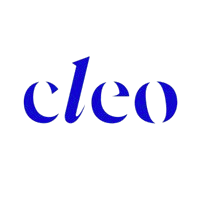

### **Parcours Makers - Module 1 - Prompt engineering avancé**
##**Cours 3 : Orchestrer des agents ReAct avec LangGraph**

Ce notebook illustre l'implémentation d'un assistant marketing intelligent
qui combine plusieurs technologies d'IA pour automatiser l'analyse de sentiment
et la génération de contenu personnalisé.

Cas d'usage : Une équipe marketing veut analyser les retours clients et générer
automatiquement du contenu publicitaire adapté aux sentiments exprimés.

Technologies utilisées :
- Agent ReAct : Analyse structurée des retours clients
- LangGraph : Workflow de génération de contenu
- Streaming : Génération de contenu en temps réel
- Retry Logic : Robustesse face aux limitations API
- Vector Memory : Apprentissage des préférences clients

## 1. Préparer l’environnement

Avant de commencer, assurons-nous que toutes les bibliothèques nécessaires sont bien installées et que l'accès à l'API OpenAI est configuré.

Exécutez la cellule suivante **une seule fois** pour installer les bibliothèques utilisées dans ce notebook :

In [ ]:
!pip install -q \
  faiss-cpu==1.11.0.post1 \
  langchain==0.3.26 \
  langchain-community==0.3.27 \
  langchain-core==0.3.69 \
  langchain-openai==0.3.28 \
  langchain-text-splitters==0.3.8 \
  langgraph==0.5.3 \
  langgraph-checkpoint==2.1.1 \
  langgraph-prebuilt==0.5.2 \
  langgraph-sdk==0.1.73 \
  openai==1.96.1 \
  python-dotenv==1.1.1 \
  tiktoken==0.9.0 \
  wikipedia==1.4.0


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from dotenv import load_dotenv
import os, getpass, openai
import time
import json
import warnings
from typing import TypedDict, List
import numpy as np

load_dotenv()
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Entrez votre clé OpenAI : ")

openai.api_key = os.getenv("OPENAI_API_KEY")

Entrez votre clé OpenAI : ··········


In [ ]:
# Imports pour les différentes fonctionnalités
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.agents import create_react_agent, AgentExecutor
from langchain.prompts import PromptTemplate
from langchain.tools import Tool
from langchain.memory import VectorStoreRetrieverMemory
from langchain_community.vectorstores import FAISS
from langgraph.graph import StateGraph, END

## 2. Agent ReAct pour l'analyse de sentiment

Un agent ReAct combine raisonnement et action pour résoudre des problèmes complexes.
Dans notre cas marketing, il va analyser les retours clients en plusieurs étapes :
1. Lire le retour client
2. Identifier les mots-clés émotionnels  
3. Analyser le sentiment global
4. Proposer une stratégie de réponse

Avantages :
- Processus d'analyse transparent et traceable
- Capacité à utiliser des outils externes (bases de données, APIs)
- Raisonnement étape par étape

Limites :
- Plus lent qu'une analyse directe
- Peut tourner en boucle sur des problèmes complexes
- Coût en tokens plus élevé

In [ ]:
# Configuration du modèle LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)  # Température légèrement créative pour le marketing

# Outil d'analyse de sentiment personnalisé
def analyze_customer_feedback(feedback_text):
    """
    Simule une analyse de sentiment avancée avec contexte métier
    En réalité, ceci pourrait appeler une API spécialisée ou une base de données
    """
    # Simulation d'une analyse plus sophistiquée
    prompt = f"""
    Analyse ce retour client du point de vue marketing :

    Retour : "{feedback_text}"

    Fournis :
    1. Sentiment (positif/négatif/neutre) avec score 0-10
    2. Mots-clés émotionnels identifiés
    3. Aspect produit/service mentionné
    4. Niveau d'urgence de réponse (bas/moyen/élevé)

    Format JSON uniquement.
    """

    response = llm.invoke(prompt)
    return response.content

# Création de l'outil pour l'agent
sentiment_analysis_tool = Tool(
    name="Customer Sentiment Analyzer",
    func=analyze_customer_feedback,
    description="Analyse le sentiment et les aspects clés d'un retour client pour stratégie marketing"
)

# Template ReAct spécialisé pour le marketing
marketing_react_template = """Tu es un expert en analyse marketing. Tu analyses les retours clients de manière systématique.

Outils disponibles :
{tools}

Format d'analyse :

Question: le retour client à analyser
Thought: je dois réfléchir à l'approche d'analyse
Action: l'action à prendre, doit être l'un de [{tool_names}]
Action Input: le texte du retour client
Observation: le résultat de l'analyse
... (répéter Thought/Action/Action Input/Observation si nécessaire)
Thought: j'ai maintenant toutes les informations nécessaires
Final Answer: recommandations marketing basées sur l'analyse

Commence !

Question: {input}
Thought:{agent_scratchpad}"""

marketing_prompt = PromptTemplate(
    template=marketing_react_template,
    input_variables=["input", "tools", "tool_names", "agent_scratchpad"],
)

# Création de l'agent marketing ReAct
marketing_react_agent = create_react_agent(
    llm,
    [sentiment_analysis_tool],
    marketing_prompt
)

marketing_agent = AgentExecutor(
    agent=marketing_react_agent,
    tools=[sentiment_analysis_tool],
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=3,  # Limite pour éviter les boucles infinies
    max_execution_time=30
)

In [ ]:
# Test de l'agent avec un retour client typique
customer_feedback = """
J'ai acheté votre nouveau produit la semaine dernière et je suis vraiment déçu.
La qualité n'est pas au rendez-vous par rapport au prix payé. Le service client
m'a fait attendre 2 heures pour une réponse qui n'était même pas utile.
Je réfléchis sérieusement à demander un remboursement.
"""

print("=== ANALYSE DE SENTIMENT AVEC AGENT REACT ===")
print(f"Retour client analysé : {customer_feedback[:100]}...")

result = marketing_agent.invoke({"input": customer_feedback})
print("\n" + "="*60)
print("RECOMMANDATIONS MARKETING:")
print("="*60)
print(result['output'])

=== ANALYSE DE SENTIMENT AVEC AGENT REACT ===
Retour client analysé : 
J'ai acheté votre nouveau produit la semaine dernière et je suis vraiment déçu. 
La qualité n'est p...


> Entering new AgentExecutor chain...
Je dois réfléchir à l'approche d'analyse pour comprendre les sentiments et les aspects clés de ce retour client. Le client mentionne plusieurs points négatifs concernant la qualité du produit, le prix, et le service client. Je vais utiliser l'outil Customer Sentiment Analyzer pour obtenir une analyse détaillée.

Action: Customer Sentiment Analyzer
Action Input: "J'ai acheté votre nouveau produit la semaine dernière et je suis vraiment déçu. La qualité n'est pas au rendez-vous par rapport au prix payé. Le service client m'a fait attendre 2 heures pour une réponse qui n'était même pas utile. Je réfléchis sérieusement à demander un remboursement."
```json
{
    "sentiment": {
        "type": "négatif",
        "score": 2
    },
    "mots_cles_emotionnels": [
        "déçu",
    

## 3. Workflow LangGraph pour génération de contenu

LangGraph permet de créer des workflows complexes avec plusieurs étapes
et conditions. Parfait pour des processus marketing multi-étapes :

1. Analyse du brief → 2. Génération d'idées → 3. Rédaction → 4. Optimisation

Avantages :
- Orchestration complexe de tâches
- Gestion d'état entre les étapes
- Possibilité de conditions et boucles
- Réutilisabilité des composants

Limites :
- Complexité de configuration
- Debug plus difficile
- Overhead pour des tâches simples

In [ ]:
# Définition du schéma d'état pour le workflow marketing
class MarketingWorkflowState(TypedDict):
    brief: str                    # Brief marketing initial
    target_audience: str          # Audience cible identifiée
    content_ideas: List[str]      # Idées de contenu générées
    final_content: str           # Contenu final optimisé
    performance_prediction: str   # Prédiction de performance

# Node 1: Analyse du brief et identification de l'audience
def analyze_marketing_brief_node(state: MarketingWorkflowState) -> MarketingWorkflowState:
    """
    Analyse le brief marketing et identifie l'audience cible

    Points critiques :
    - Extraction des insights clés du brief
    - Identification précise de la cible
    - Définition des objectifs mesurables
    """
    brief_analysis_prompt = f"""
    Analyse ce brief marketing et identifie l'audience cible principale :

    Brief : {state['brief']}

    Fournis :
    1. Audience cible principale (âge, démographie + psychographie, eg. 25-50 ans)
    2. 3 insights clés du brief
    3. Objectif principal de la campagne

    Réponds de manière concise et actionnable. Chaque point à fournir doit être mis après retour à ligne.
    """

    analysis = llm.invoke(brief_analysis_prompt).content

    # Extraction de l'audience (simulation - en réalité utiliserait du parsing plus sophistiqué)
    target_audience = "Audience analysée : " + analysis.split('\n')[0] if analysis else "Audience générale"

    return {
        "brief": state["brief"],
        "target_audience": target_audience,
        "content_ideas": [],
        "final_content": "",
        "performance_prediction": ""
    }

# Node 2: Génération d'idées créatives
def generate_content_ideas_node(state: MarketingWorkflowState) -> MarketingWorkflowState:
    """
    Génère plusieurs idées de contenu basées sur l'analyse

    Bonnes pratiques :
    - Diversité des formats (texte, visuel, vidéo)
    - Adaptation au canal de diffusion
    - Tests A/B potentiels
    """
    ideas_prompt = f"""
    Génère 3 idées créatives pour ce contexte marketing :

    Brief : {state['brief']}
    Audience : {state['target_audience']}

    Pour chaque idée, fournis :
    - Concept créatif principal
    - Format recommandé (post social, email, pub display...)
    - Accroche principale

    Sois créatif mais reste aligné sur les objectifs business.
    """

    ideas_response = llm.invoke(ideas_prompt).content

    # Extraction des idées (simplifiée)
    content_ideas = ideas_response.split('\n\n') if ideas_response else ["Idée par défaut"]

    return {
        "brief": state["brief"],
        "target_audience": state["target_audience"],
        "content_ideas": content_ideas,
        "final_content": "",
        "performance_prediction": ""
    }

# Node 3: Rédaction du contenu final optimisé
def create_final_content_node(state: MarketingWorkflowState) -> MarketingWorkflowState:
    """
    Sélectionne la meilleure idée et crée le contenu final

    Critères d'optimisation :
    - Clarté du message
    - Call-to-action efficace
    - Adaptation au canal
    - Respect des contraintes (caractères, format...)
    """
    content_creation_prompt = f"""
    Crée le contenu marketing final optimisé :

    Brief : {state['brief']}
    Audience : {state['target_audience']}
    Meilleures idées : {state['content_ideas'][:2]}  # Prend les 2 premières

    Crée un contenu publicitaire de 150 mots maximum avec :
    - Titre accrocheur
    - Message principal convaincant
    - Call-to-action clair
    - Ton adapté à l'audience

    Optimise pour l'engagement et la conversion.
    """

    final_content = llm.invoke(content_creation_prompt).content

    # Prédiction de performance (simulation)
    performance_prompt = f"""
    Évalue le potentiel de ce contenu marketing :

    Contenu : {final_content}
    Audience : {state['target_audience']}

    Donne un score de performance prédit (1-10) et justifie brièvement.
    """

    performance_prediction = llm.invoke(performance_prompt).content

    return {
        "brief": state["brief"],
        "target_audience": state["target_audience"],
        "content_ideas": state["content_ideas"],
        "final_content": final_content,
        "performance_prediction": performance_prediction
    }


In [ ]:
# Construction du workflow LangGraph
marketing_workflow = StateGraph(MarketingWorkflowState)
marketing_workflow.add_node("BriefAnalysis", analyze_marketing_brief_node)
marketing_workflow.add_node("IdeaGeneration", generate_content_ideas_node)
marketing_workflow.add_node("ContentCreation", create_final_content_node)

# Définition du flux
marketing_workflow.set_entry_point("BriefAnalysis")
marketing_workflow.add_edge("BriefAnalysis", "IdeaGeneration")
marketing_workflow.add_edge("IdeaGeneration", "ContentCreation")
marketing_workflow.add_edge("ContentCreation", END)

# Compilation du workflow
content_generation_graph = marketing_workflow.compile()


In [ ]:
# Test du workflow avec un brief marketing réel
marketing_brief = """
Nous lançons une nouvelle application mobile de fitness pour les professionnels
occupés âgés de 25-45 ans. L'app propose des séances de 15 minutes adaptées
aux emplois du temps chargés. Objectif : acquérir 1000 utilisateurs en 2 mois
avec un budget publicitaire de 10k€. Public cible : cadres urbains soucieux
de leur santé mais manquant de temps.
"""

print(f"Brief marketing : {marketing_brief[:150]}...")

workflow_result = content_generation_graph.invoke({
    "brief": marketing_brief,
    "target_audience": "",
    "content_ideas": [],
    "final_content": "",
    "performance_prediction": ""
})

print("\n" + "="*60)
print("RÉSULTAT DU WORKFLOW DE GÉNÉRATION:")
print("="*60)
print(f"Audience identifiée : {workflow_result['target_audience']}")
print(f"\nContenu final :\n{workflow_result['final_content']}")
print(f"\nPrédiction de performance :\n{workflow_result['performance_prediction']}")

Brief marketing : 
Nous lançons une nouvelle application mobile de fitness pour les professionnels 
occupés âgés de 25-45 ans. L'app propose des séances de 15 minutes a...

RÉSULTAT DU WORKFLOW DE GÉNÉRATION:
Audience identifiée : Audience analysée : 1. Audience cible principale : Professionnels urbains âgés de 25-45 ans, principalement des cadres, soucieux de leur santé mais ayant des emplois du temps chargés.

Contenu final :
**Titre accrocheur :** "Fitness Express : Votre Pause Santé en 15 Minutes !"

**Message principal convaincant :** Vous êtes un professionnel urbain avec un emploi du temps chargé, mais vous ne voulez pas sacrifier votre santé ? Découvrez Fitness Express, l'application de fitness conçue spécialement pour vous. En seulement 15 minutes, transformez votre pause café en une séance d'entraînement efficace. Plus besoin de choisir entre carrière et bien-être !

**Call-to-action clair :** Téléchargez Fitness Express aujourd'hui et commencez votre transformation en un cli

In [ ]:
workflow_result["target_audience"]

'Audience analysée : 1. **Audience cible principale :**'

## 4. Streaming pour génération en temps réel

Le streaming permet d'afficher le contenu au fur et à mesure de sa génération,
améliorant l'expérience utilisateur et donnant l'impression de rapidité.

Avantages en Marketing:
- Feedback immédiat pour l'équipe créative
- Possibilité d'ajuster en cours de génération
- Expérience utilisateur plus fluide
- Réduction de la perception d'attente

Limites :
- Impossible de valider avant affichage
- Gestion d'erreurs plus complexe
- Pas adapté à tous les cas d'usage

In [ ]:
def stream_marketing_content(prompt, max_tokens=300):
    """
    Génère du contenu marketing en streaming avec feedback temps réel

    Args:
        prompt: Le prompt marketing
        max_tokens: Limite de tokens pour contrôler la longueur
    """
    print("Génération en cours...")
    print("-" * 50)

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{
                "role": "system",
                "content": "Tu es un expert en copywriting. Génère du contenu marketing percutant et professionnel."
            }, {
                "role": "user",
                "content": prompt
            }],
            stream=True,
            max_tokens=max_tokens,
            temperature=0.7  # Plus de créativité pour le contenu marketing
        )

        full_content = ""
        for chunk in response:
            if chunk.choices[0].delta.content is not None:
                content_piece = chunk.choices[0].delta.content
                print(content_piece, end="", flush=True)
                full_content += content_piece

        print("\n" + "-" * 50)
        print("Génération terminée!")
        return full_content

    except Exception as e:
        print(f"Erreur lors du streaming : {e}")
        return None

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Test du streaming avec différents types de contenu marketing
streaming_prompts = [
    "Écris un email marketing pour promouvoir une offre flash de 48h sur des produits tech",
    "Crée un post LinkedIn pour annoncer le lancement d'une formation en marketing digital",
    "Rédige une annonce Facebook pour un service de livraison de repas healthy"
]

for i, prompt in enumerate(streaming_prompts, 1):
    print(f"\n{'='*20} STREAMING TEST {i} {'='*20}")
    print(f"Prompt : {prompt}")
    print()
    generated_content = stream_marketing_content(prompt)


==================== STREAMING TEST 1 ====================
Prompt : Écris un email marketing pour promouvoir une offre flash de 48h sur des produits tech

Génération en cours...
--------------------------------------------------
Objet : 🚀 Offre Flash 48h : Jusqu'à -50% sur nos produits tech !

Cher(e) [Prénom],

C'est le moment de faire passer votre expérience technologique au niveau supérieur ! Nous sommes ravis de vous annoncer notre Offre Flash exclusive de 48 heures, avec des réductions allant jusqu'à 50% sur une sélection de nos produits tech les plus populaires.

🎯 Pourquoi cette offre est-elle incontournable ?
- **Remises Éblouissantes** : Profitez de réductions spectaculaires sur des appareils de pointe.
- **Stock Limité** : Les premiers arrivés seront les premiers servis !
- **Qualité Garantie** : Chaque produit est sélectionné pour sa performance et sa durabilité.

🕒 L'horloge tourne !
Cette offre exceptionnelle commence maintenant et se termine dans 48 heures précises. Ne l

## 5. Gestion robuste des appels API

En production marketing, la robustesse est cruciale :
- Campagnes en temps réel
- Deadlines serrées
- Coûts des échecs élevés

La gestion d'erreurs doit être sophistiquée avec :
- Retry exponentiel pour les rate limits
- Fallbacks pour les timeouts
- Monitoring des erreurs
- Dégradation gracieuse

In [ ]:
def robust_marketing_api_call(messages, model="gpt-4o", max_retries=3, use_fallback=True):
    """
    Appel API robuste spécialement conçu pour les besoins marketing

    Args:
        messages: Messages pour l'API
        model: Modèle à utiliser
        max_retries: Nombre de tentatives
        use_fallback: Utiliser un modèle de fallback si échec

    Returns:
        Réponse API ou contenu de fallback
    """

    fallback_model = "gpt-3.5-turbo"  # Modèle de secours plus rapide/moins cher

    for attempt in range(max_retries):
        try:
            current_model = model if attempt < 2 else fallback_model  # Fallback après 2 échecs

            response = client.chat.completions.create(
                model=current_model,
                messages=messages,
                timeout=30  # Timeout adapté au marketing (réactivité importante)
            )

            if attempt > 0:
                print(f"Succès après {attempt + 1} tentatives avec modèle {current_model}")

            return response

        except openai.RateLimitError as e:
            wait_time = min(2 ** attempt, 32)  # Cap à 32 secondes
            print(f"Rate limit - Tentative {attempt + 1}/{max_retries} - Attente {wait_time}s")
            if attempt < max_retries - 1:
                time.sleep(wait_time)
            else:
                if use_fallback:
                    return generate_fallback_content(messages)
                raise e

        except openai.APITimeoutError as e:
            print(f"Timeout API - Tentative {attempt + 1}/{max_retries}")
            if attempt < max_retries - 1:
                time.sleep(1)
            else:
                if use_fallback:
                    return generate_fallback_content(messages)
                raise e

        except Exception as e:
            print(f"Erreur inattendue : {e}")
            if attempt == max_retries - 1 and use_fallback:
                return generate_fallback_content(messages)
            elif attempt < max_retries - 1:
                time.sleep(1)
            else:
                raise e

    return None

def generate_fallback_content(messages):
    """
    Génère du contenu de fallback basique si l'API échoue complètement
    Important en marketing pour ne jamais laisser l'utilisateur sans réponse
    """
    print("Génération de contenu de fallback...")

    # Analyse basique du prompt pour générer un fallback pertinent
    user_message = next((msg["content"] for msg in messages if msg["role"] == "user"), "")

    if "email" in user_message.lower():
        fallback_content = """
        Objet : Offre spéciale à ne pas manquer !

        Bonjour,

        Nous avons une offre exceptionnelle pour vous.

        [Votre contenu personnalisé ici]

        Cordialement,
        L'équipe
        """
    elif "post" in user_message.lower() or "social" in user_message.lower():
        fallback_content = """
        Découvrez notre nouveauté !

        [Votre message personnalisé]

        #marketing #innovation
        """
    else:
        fallback_content = """
        Contenu marketing généré automatiquement.

        [Personnalisez ce contenu selon vos besoins]

        Pour plus d'informations, contactez notre équipe.
        """

    # Simulation d'un objet response basique
    class FallbackResponse:
        def __init__(self, content):
            self.choices = [type('obj', (object,), {
                'message': type('obj', (object,), {'content': content})()
            })()]

    return FallbackResponse(fallback_content)

def extract_content_safely(response):
    """Extraction sécurisée du contenu avec gestion des fallbacks"""
    try:
        if hasattr(response, 'choices') and response.choices:
            return response.choices[0].message.content
        return "Erreur : impossible d'extraire le contenu"
    except AttributeError:
        return "Erreur : format de réponse inattendu"

In [ ]:
# Test de la robustesse avec simulation d'erreurs
marketing_messages = [
    {"role": "system", "content": "Tu es un expert en marketing digital."},
    {"role": "user", "content": "Crée une campagne publicitaire pour un produit écologique innovant"}
]

print("Test d'appel API robuste...")
try:
    robust_response = robust_marketing_api_call(marketing_messages)
    content = extract_content_safely(robust_response)
    print("Contenu généré avec succès :")
    print(content[:200] + "..." if len(content) > 200 else content)
except Exception as e:
    print(f"Échec complet après tous les fallbacks : {e}")

Test d'appel API robuste...
Contenu généré avec succès :
Créer une campagne publicitaire pour un produit écologique innovant nécessite une approche stratégique qui met en avant ses avantages uniques, tout en sensibilisant le public aux enjeux environnementa...


## 6. Mémoire vectorielle

La mémoire vectorielle permet de :
- Stocker les préférences clients historiques
- Retrouver des campagnes similaires réussies
- Personnaliser le contenu basé sur l'historique
- Apprendre des performances passées

Application Marketing :
- Recommandations de contenu basées sur l'historique
- Réutilisation de créas performantes
- Segmentation dynamique des audiences
- Optimisation continue des messages

Point d'attention :
- Qualité des embeddings critique
- Gestion de la vie privée (RGPD)
- Biais potentiels dans les recommandations
- Coût de stockage et calcul

In [ ]:
# Suppression des warnings pour la démo
warnings.filterwarnings("ignore", category=DeprecationWarning)

class MarketingMemoryManager:
    """
    Gestionnaire de mémoire spécialisé pour les cas d'usage marketing

    Fonctionnalités :
    - Stockage des campagnes passées
    - Recherche de contenu similaire
    - Analyse de performance historique
    - Recommandations personnalisées
    """

    def __init__(self, api_key=None, k_documents=5):
        self.embeddings = OpenAIEmbeddings(api_key=api_key) if api_key else OpenAIEmbeddings()
        self.k_documents = k_documents

        # Initialisation avec des données marketing de base
        initial_data = [
            "Campagne email Black Friday - taux d'ouverture 25% - audience 25-45 ans",
            "Post Instagram produit bio - 500 likes - audience éco-responsable",
            "Pub Facebook formation digital - CPC 1.2€ - audience entrepreneurs"
        ]

        self.vectorstore = FAISS.from_texts(
            texts=initial_data,
            embedding=self.embeddings,
            metadatas=[
                {"type": "email", "performance": "high", "audience": "general"},
                {"type": "social", "performance": "medium", "audience": "eco"},
                {"type": "ads", "performance": "low", "audience": "business"}
            ]
        )

    def add_campaign_result(self, campaign_description, performance_metrics, audience_data, campaign_type):
        """
        Ajoute les résultats d'une campagne à la mémoire

        Args:
            campaign_description: Description de la campagne
            performance_metrics: Métriques de performance (CTR, conversions, etc.)
            audience_data: Données sur l'audience ciblée
            campaign_type: Type de campagne (email, social, ads, etc.)
        """

        # Construction du texte enrichi pour l'embedding
        enriched_text = f"""
        Campagne {campaign_type}: {campaign_description}
        Performance: {performance_metrics}
        Audience: {audience_data}
        """

        # Métadonnées structurées pour le filtrage
        metadata = {
            "type": campaign_type,
            "timestamp": str(np.datetime64('now')),
            "performance_score": self._calculate_performance_score(performance_metrics)
        }

        self.vectorstore.add_texts(
            texts=[enriched_text.strip()],
            metadatas=[metadata]
        )

        print(f"Campagne {campaign_type} ajoutée à la mémoire marketing")

    def find_similar_campaigns(self, query, campaign_type=None, min_performance=None):
        """
        Trouve des campagnes similaires pour inspiration

        Args:
            query: Description de ce qu'on cherche
            campaign_type: Filtre par type de campagne (optionnel)
            min_performance: Score minimum de performance (optionnel)
        """

        # Recherche avec score de similarité
        results = self.vectorstore.similarity_search_with_score(query, k=self.k_documents)

        # Filtrage optionnel par métadonnées
        filtered_results = []
        for doc, score in results:
            metadata = doc.metadata

            # Filtres
            if campaign_type and metadata.get("type") != campaign_type:
                continue
            if min_performance and metadata.get("performance_score", 0) < min_performance:
                continue

            filtered_results.append((doc, score, metadata))

        return filtered_results

    def get_content_recommendations(self, brief, target_audience):
        """
        Recommande du contenu basé sur l'historique et le brief
        """

        search_query = f"brief: {brief} audience: {target_audience}"
        similar_campaigns = self.find_similar_campaigns(search_query, min_performance=0.5)

        if not similar_campaigns:
            return "Aucune campagne similaire trouvée. Création de contenu original recommandée."

        recommendations = "Recommandations basées sur l'historique :\n\n"

        for i, (doc, similarity_score, metadata) in enumerate(similar_campaigns[:3], 1):
            recommendations += f"{i}. {doc.page_content}\n"
            recommendations += f"   Similarité: {1-similarity_score:.2f} | Performance passée: {metadata.get('performance_score', 'N/A')}\n\n"

        return recommendations

    def _calculate_performance_score(self, performance_metrics):
        """
        Calcule un score de performance normalisé (0-1)
        En réalité, ceci analyserait des métriques réelles (CTR, ROI, etc.)
        """

        # Simulation basée sur des mots-clés dans les métriques
        score = 0.5  # Score de base

        if "élevé" in performance_metrics.lower() or "high" in performance_metrics.lower():
            score += 0.3
        if "excellent" in performance_metrics.lower():
            score += 0.2
        if "faible" in performance_metrics.lower() or "low" in performance_metrics.lower():
            score -= 0.2

        return max(0, min(1, score))  # Clamp entre 0 et 1

    def analyze_audience_preferences(self, audience_segment):
        """
        Analyse les préférences d'un segment d'audience basé sur l'historique
        """

        query = f"audience {audience_segment}"
        relevant_campaigns = self.find_similar_campaigns(query)

        if not relevant_campaigns:
            return f"Pas assez de données historiques pour l'audience : {audience_segment}"

        analysis = f"Analyse des préférences pour '{audience_segment}' :\n\n"

        # Analyse des types de campagnes les plus performants
        campaign_types = {}
        performance_avg = {}

        for doc, score, metadata in relevant_campaigns:
            camp_type = metadata.get("type", "unknown")
            perf_score = metadata.get("performance_score", 0)

            if camp_type not in campaign_types:
                campaign_types[camp_type] = 0
                performance_avg[camp_type] = []

            campaign_types[camp_type] += 1
            performance_avg[camp_type].append(perf_score)

        # Recommandations basées sur l'analyse
        for camp_type, count in campaign_types.items():
            avg_perf = sum(performance_avg[camp_type]) / len(performance_avg[camp_type])
            analysis += f"- {camp_type.title()}: {count} campagnes, performance moyenne: {avg_perf:.2f}\n"

        return analysis

In [ ]:
# Initialisation et test du gestionnaire de mémoire marketing

marketing_memory = MarketingMemoryManager()

# Ajout de campagnes fictives mais réalistes
sample_campaigns = [
    {
        "description": "Email de bienvenue avec code promo 10%",
        "performance": "Taux d'ouverture 35%, CTR 8%, conversions élevées",
        "audience": "Nouveaux inscrits 18-35 ans",
        "type": "email"
    },
    {
        "description": "Story Instagram avant/après transformation fitness",
        "performance": "10k vues, 800 likes, engagement élevé",
        "audience": "Femmes 25-40 ans fitness",
        "type": "social"
    },
    {
        "description": "Pub Google Ads formation marketing digital",
        "performance": "CPC 1.5€, taux de conversion 12%, ROI excellent",
        "audience": "Entrepreneurs, freelances",
        "type": "ads"
    },
    {
        "description": "Newsletter mensuelle avec tips marketing",
        "performance": "Taux d'ouverture 28%, taux de clic faible",
        "audience": "Abonnés réguliers, professionnels",
        "type": "email"
    }
]

print("Ajout des campagnes à la mémoire...")
for campaign in sample_campaigns:
    marketing_memory.add_campaign_result(
        campaign["description"],
        campaign["performance"],
        campaign["audience"],
        campaign["type"]
    )

Ajout des campagnes à la mémoire...
Campagne email ajoutée à la mémoire marketing
Campagne social ajoutée à la mémoire marketing
Campagne ads ajoutée à la mémoire marketing
Campagne email ajoutée à la mémoire marketing


In [ ]:
# Test des fonctionnalités de recommandation

# Recherche de campagnes similaires
query_test = "campagne email avec offre promotionnelle pour nouveaux clients"
print(f"Recherche : {query_test}")

similar_campaigns = marketing_memory.find_similar_campaigns(query_test, campaign_type="email")

print(f"\nCampagnes similaires trouvées ({len(similar_campaigns)}) :")
for i, (doc, score, metadata) in enumerate(similar_campaigns, 1):
    print(f"\n{i}. {doc.page_content}")
    print(f"   Score de similarité: {1-score:.3f}")
    print(f"   Performance: {metadata.get('performance_score', 'N/A')}")

# Analyse des préférences d'audience
print("\n=== ANALYSE DES PRÉFÉRENCES D'AUDIENCE ===")
audience_analysis = marketing_memory.analyze_audience_preferences("femmes 25-40 ans")
print(audience_analysis)

# Recommandations pour un nouveau brief
print("\n=== RECOMMANDATIONS POUR NOUVEAU BRIEF ===")
new_brief = "Promouvoir une application de méditation pour réduire le stress"
target_audience = "Professionnels urbains stressés"

recommendations = marketing_memory.get_content_recommendations(new_brief, target_audience)
print(f"Brief : {new_brief}")
print(f"Audience : {target_audience}")
print(f"\n{recommendations}")

Recherche : campagne email avec offre promotionnelle pour nouveaux clients

Campagnes similaires trouvées (3) :

1. Campagne email: Email de bienvenue avec code promo 10%
        Performance: Taux d'ouverture 35%, CTR 8%, conversions élevées
        Audience: Nouveaux inscrits 18-35 ans
   Score de similarité: 0.780
   Performance: 0.8

2. Campagne email Black Friday - taux d'ouverture 25% - audience 25-45 ans
   Score de similarité: 0.751
   Performance: N/A

3. Campagne email: Newsletter mensuelle avec tips marketing
        Performance: Taux d'ouverture 28%, taux de clic faible
        Audience: Abonnés réguliers, professionnels
   Score de similarité: 0.749
   Performance: 0.3

=== ANALYSE DES PRÉFÉRENCES D'AUDIENCE ===
Analyse des préférences pour 'femmes 25-40 ans' :

- Email: 3 campagnes, performance moyenne: 0.37
- Social: 2 campagnes, performance moyenne: 0.40


=== RECOMMANDATIONS POUR NOUVEAU BRIEF ===
Brief : Promouvoir une application de méditation pour réduire le stress
A

## Pour aller plus loin

* **Ajouter une boucle de feedback humain** : Intégrer un mécanisme de revue manuelle dans le workflow, où un humain valide ou ajuste les recommandations avant publication.

* **Orchestrer plusieurs agents spécialisés** : Créer un graphe LangGraph avec des agents distincts pour la rédaction, l'optimisation SEO, et l'adaptation au canal (email, réseau social, landing page…).

* **Exploiter les signaux comportementaux** : Connecter le système à des métriques d’engagement réel (taux d’ouverture, clics, conversion) pour affiner les recommandations futures.

* **Gérer des scénarios multilingues** : Adapter le pipeline pour détecter la langue des retours clients et générer du contenu marketing multilingue automatiquement.

* **Mettre en production un assistant marketing** : Déployer tout ou partie de ce pipeline dans une application (front léger) à destination d’équipes marketing non techniques.


## 8. Conclusion

Ce notebook a montré comment combiner plusieurs briques technologiques pour construire un système marketing intelligent basé sur des agents ReAct et un workflow LangGraph. Chaque composant – de l’analyse de sentiment à la mémoire vectorielle – contribue à une chaîne décisionnelle cohérente, traçable et personnalisée. Ce type d’orchestration ouvre la voie à des assistants IA professionnels capables de raisonner, d’agir, de s’adapter et d’apprendre de manière continue.
